In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


#### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder,MaxAbsScaler,OrdinalEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score

## Load the dataset

In [3]:
train_data=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
test_data=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")

In [4]:
# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

Let's get some proper idea of the features in the dataset. We use the **info()** method to get the necessary details such as total counts, data types, etc from the dataset.

In [5]:
print(train_data.info(), test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

We have the train and test dataset but let's copy and make a separate dataframe to perform the data analysis and other operations. This will help us preserve the original data frame.

In [6]:
# copying train dataset for eda
df=train_data.copy()

In [7]:
df.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


## Exploratory Data Analysis

In [8]:
print(f"Shape of train dataset: {train_data.shape}\nShape of test dataset:{test_data.shape}")

Shape of train dataset: (39211, 16)
Shape of test dataset:(10000, 15)


## Describe the dataframe

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,39211.0,42.120247,12.709352,18.0,33.0,40.0,50.0,95.0
balance,39211.0,5441.781719,16365.292065,-8019.0,98.0,549.0,2030.0,102127.0
duration,39211.0,439.062789,769.096291,0.0,109.0,197.0,380.0,4918.0
campaign,39211.0,5.108770,9.890153,1.0,1.0,2.0,4.0,63.0
pdays,39211.0,72.256051,160.942593,-1.0,-1.0,-1.0,-1.0,871.0
previous,39211.0,11.826171,44.140259,0.0,0.0,0.0,0.0,275.0


### Identify Feature Types

In [10]:
# Separate categorical and numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')
Categorical Features: Index(['last contact date', 'job', 'marital', 'education', 'default',
       'housing', 'loan', 'contact', 'poutcome', 'target'],
      dtype='object')


### **Age**
The age is a numerical feature. Let us plot and see the distribution of the values using a histplot.

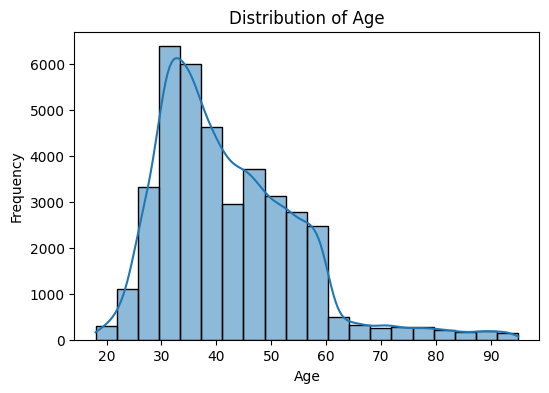

In [11]:
plt.figure(figsize=(6, 4))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [12]:
print(f"The age feature ranges from {df['age'].min()}, all the way to { df['age'].max()}")

The age feature ranges from 18, all the way to 95


### **Target variable distribution**
Let us have a look at the target and the distribution of the elements.

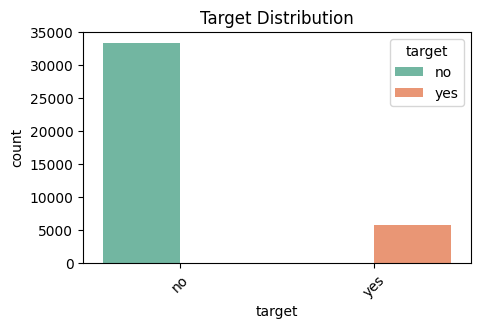

In [13]:
plt.figure(figsize=(5, 3))
sns.countplot(x='target', data=df, hue='target', palette='Set2')
plt.title("Target Distribution")
plt.xticks(rotation=45)
plt.show()

From the above plot, it appears that the **target** variable is highly imbalanced, with a significantly larger number of instances belonging to the "no" class compared to the "yes" class.
This shows that we have to use some 'Resampling' techniques to handle this data imbalance.

### **Numerical feature distribution**
Let us have a look the the distribution of the numerical features

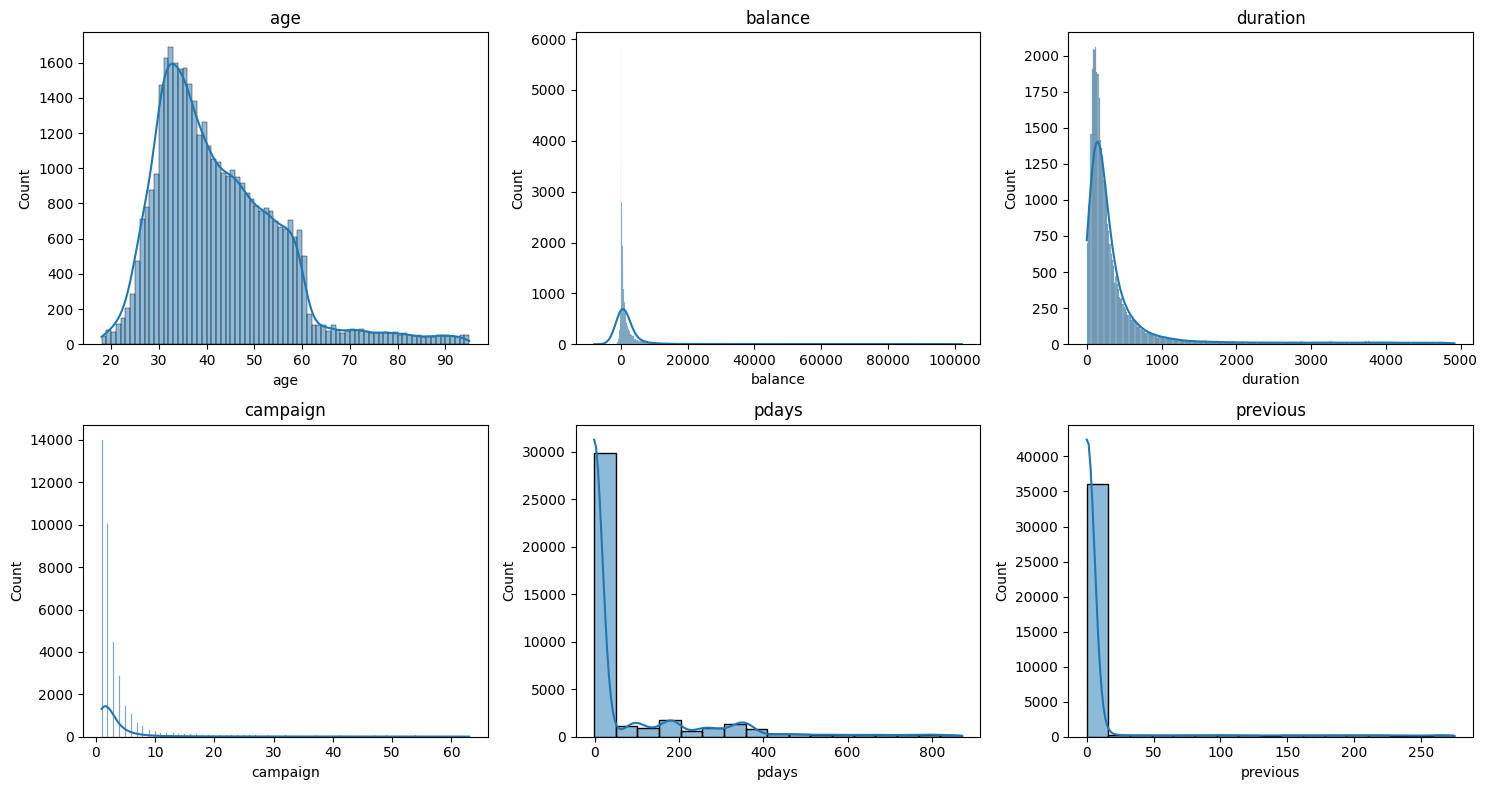

In [14]:
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

# Create subplots with 3 columns per row
num_rows = (len(numerical_features) + 2) // 3  # Calculate number of rows needed
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through numerical features and create histograms
for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], ax=axes[i], kde=True)
    axes[i].set_title(feature)

# Remove any empty subplots
for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


1. The **age** distribution is right-skewed, indicating a larger proportion is concentrated between 30 and 50 years, with fewer younger or older clients.
2. The **balance** distribution is highly right-skewed, suggesting a large number of individuals with low balances and a smaller number with very high  balances.
3. The **duration** distribution is also right-skewed, indicating that a significant number of calls are of shorter duration.
4. Similary, **campaign**, **pdays** and **previous** appears to be right-skewed.

### **Categorical features distribution**
Previously we have seen the numerical feature distribution. In this section, let us have a look at the categorical features and observe their distribution.

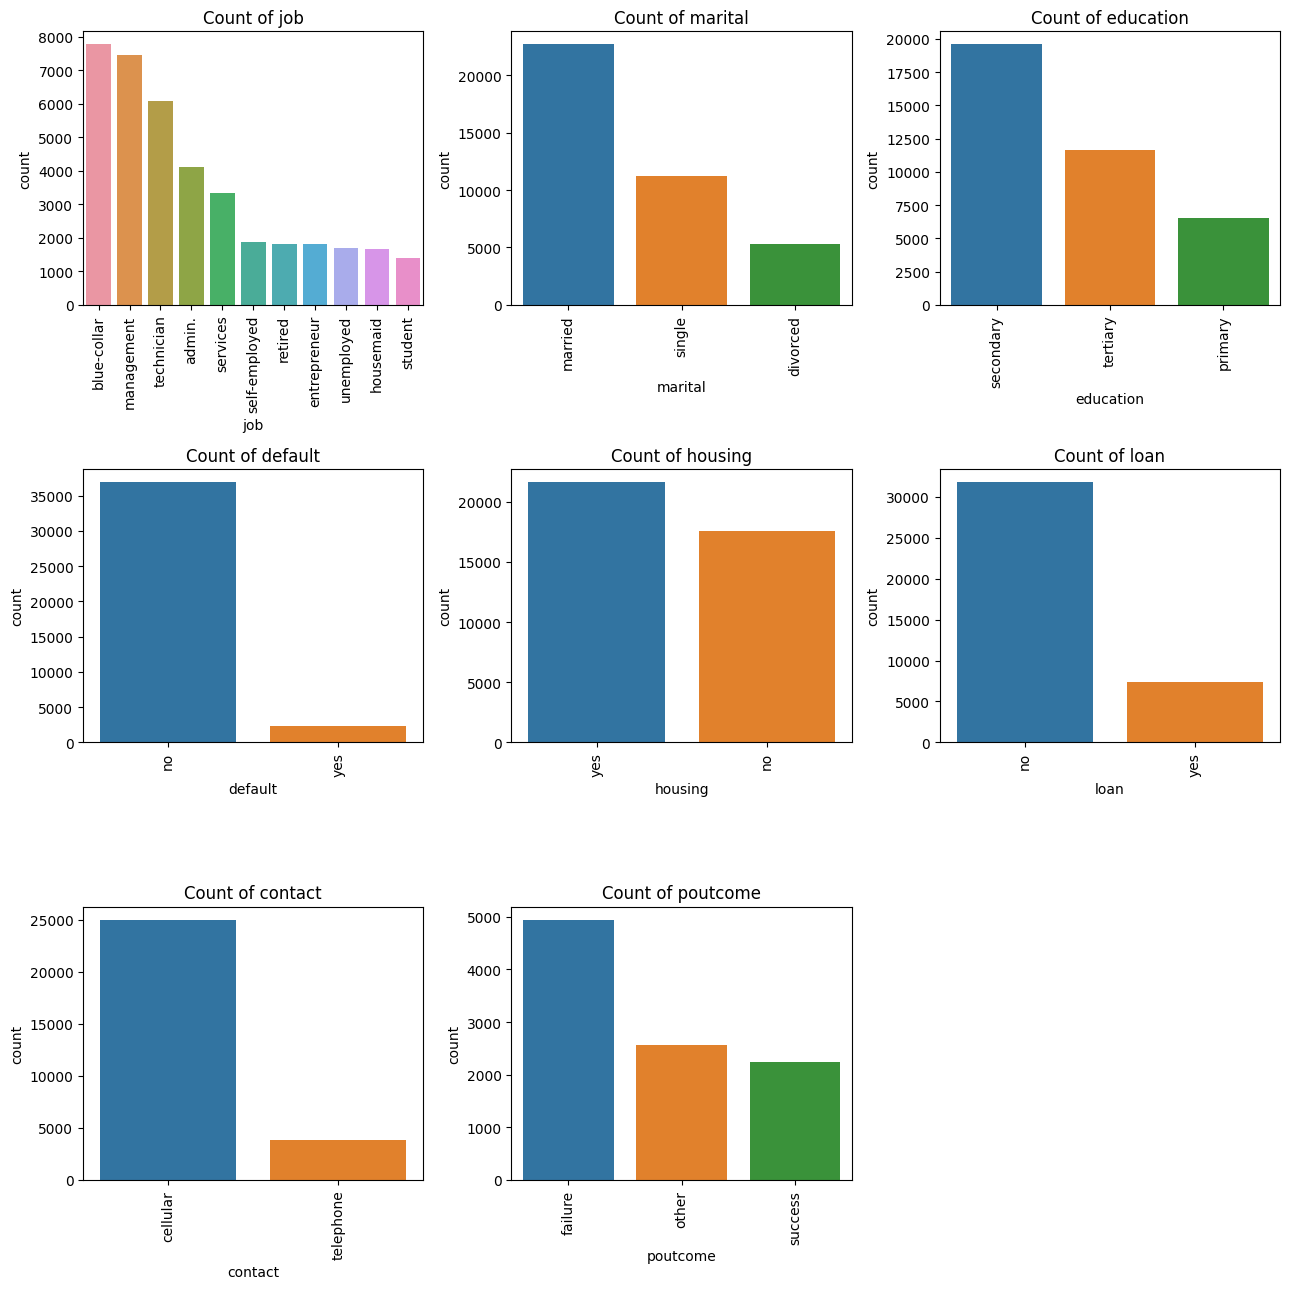

In [15]:
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
plt.figure(figsize=(13, 13))

# Loop through and plot the categorical columns
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)  # Create a grid with 3 rows and 3 columns
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Count of {col}')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

From the above distribution, it appears that:

1. For **job**, "Management" and "blue-collar" are the most common job types, while "Student" is the least common.
2. For **marital**, it looks like most of the individuals are are "married". And "Single" is the second most common, followed by "divorced."
3. For **education**, "Secondary" education is the most common while "Tertiary" education is the second most common.
4. For **default**, most individuals have not defaulted on credit. Only a small percentage have defaulted.
5. For **housing**, most individuals have house loan. Only a significant portion have no house loan.
6. For **loan**, it appears that most individuals do not have a personal loan.
7. For **contact**, most individuals were contacted via "cellular" phone. A smaller number were contacted via "telephone."
8. For **poutcome**, Most individuals have not been previously contacted. "Failure" is the most common outcome of previous contacts.

### **Poutcome vs Target**
Let us have the relationship between poutcome and the target variable.

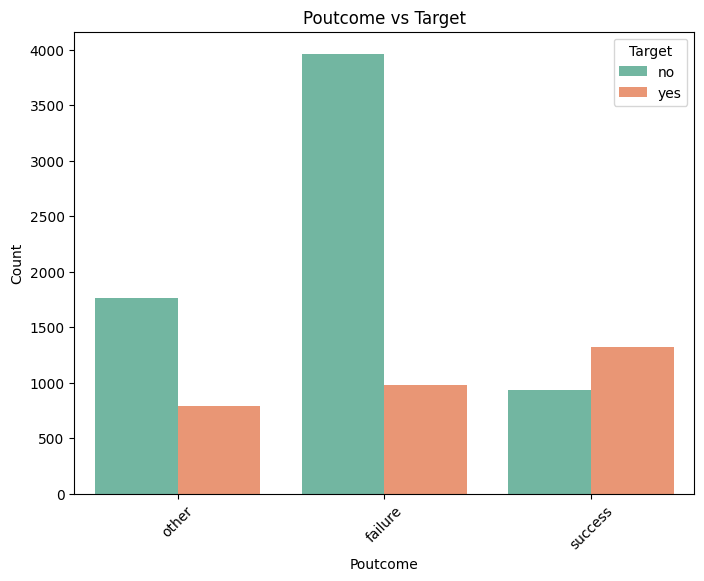

In [16]:
plt.figure(figsize=(8, 6))
sns.countplot(x='poutcome', hue='target', data=df, palette='Set2')
plt.title('Poutcome vs Target')
plt.xlabel('Poutcome')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Target')
plt.show()

From the above chart, looks like most of the previous campaign outcomes were either "failure", with a smaller number being "success". The "yes" target group appears to be more concentrated in the "success" outcome compared to the "no" target group

### **Target vs Balance**

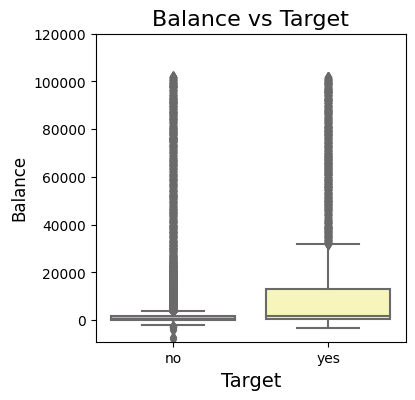

In [17]:
plt.figure(figsize=(4, 4))
sns.boxplot(x='target', y='balance', data=train_data, palette="Set3")

# Adding proper labels and title
plt.title("Balance vs Target", fontsize=16)
plt.xlabel("Target", fontsize=14)
plt.ylabel("Balance", fontsize=12)

# Adjust y-axis for better visualization
plt.ylim(-9000, 120000)  # Assuming a reasonable range for balance

# Display the plot
plt.show()

There are a few outliers in the "no" target group, indicating that there are some individuals with exceptionally high balances who are not classified as "yes."

### **Correlation between Target and Balance**

Let us check if there is any correlation between target and balance.

In [18]:
# Calculate correlation coefficient between balance and target
df1=df.copy()
# convert the yes/no to 0 and 1
df1['target'] = df1['target'].map({'yes': 1, 'no': 0})
correlation = df1['balance'].corr(df1['target'])
print(f"Correlation between balance and target: {correlation:.2f}")

Correlation between balance and target: 0.26


The value of 0.26 is closer to 0 than to 1, indicating a weak relationship.

### **Target vs Job**
Now, let us have a look at the target and the job to check if there are any pattern or relationship between these two features

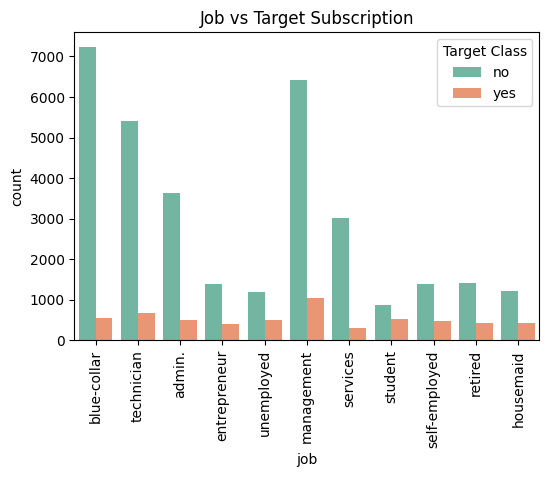

In [19]:
plt.figure(figsize=(6, 4))
sns.countplot(x='job', hue='target', data=df, palette="Set2")
plt.title("Job vs Target Subscription")
plt.xticks(rotation=90)
plt.legend(title='Target Class')
plt.show()

From the above chart,

The most common jobs among the respondents are "blue-collar", "management", followed by "technician.
Professions like "blue-collar," "technician," "management" and "admin" have lower subscription rates, suggesting that individuals in these jobs might be less likely to subscribe.

### **Education Vs Target**

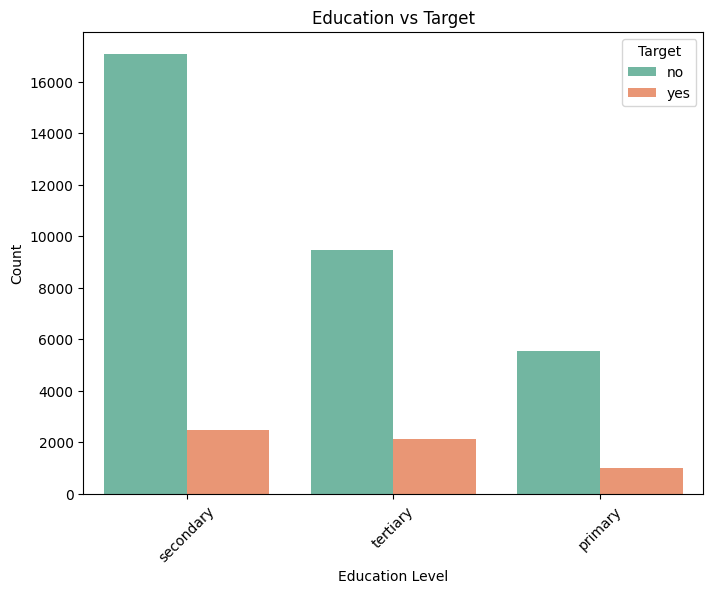

In [20]:
plt.figure(figsize=(8, 6))
sns.countplot(x='education', hue='target', data=df, palette='Set2')
plt.title('Education vs Target')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Target')
plt.show()

From the above chart, it looks like that most individuals have a secondary education level and the "yes" target group appears to be more concentrated in the tertiary education group compared to the "no" target group.

### **Housing Loan vs Target**

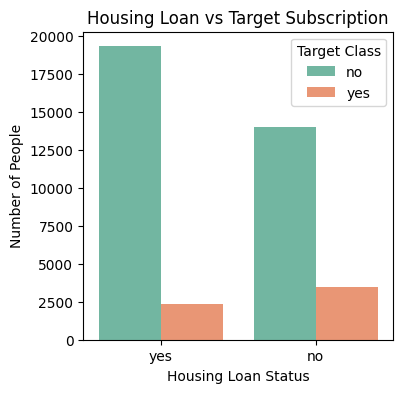

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
sns.countplot(x='housing', hue='target', data=df, palette="Set2")
plt.title("Housing Loan vs Target Subscription")
plt.xlabel("Housing Loan Status")
plt.ylabel("Number of People")
plt.legend(title='Target Class')
plt.show()

From the above chart,

People with a housing loan are less likely to subscribe compared to thos without a loan.


There is a higher subscription rate among people who do not have a housing loan.

### **Correlation between numerical features**

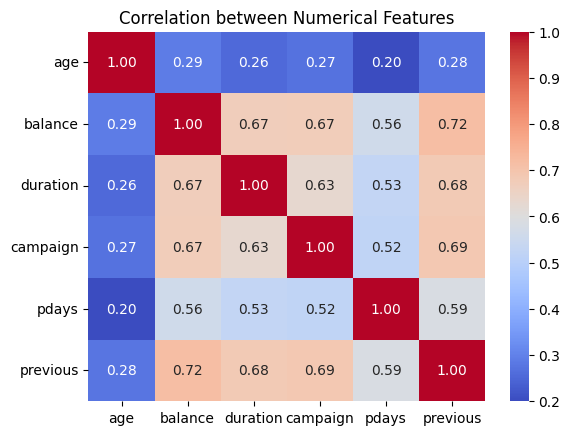

In [22]:
corr = train_data[numerical_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation between Numerical Features")
plt.show()

"Previous" has a high positive correlation with "balance" (0.72), "duration" (0.68), and "campaign" (0.69), indicating that these features tend to increase together.
Correlations involving "age" are generally weak, ranging from 0.20 to 0.29 with other feature, which suggests that many features are fairly independent of each other..

### **Outlier analysis**

Text(0.5, 1.0, 'Box Plot to analyse outliers')

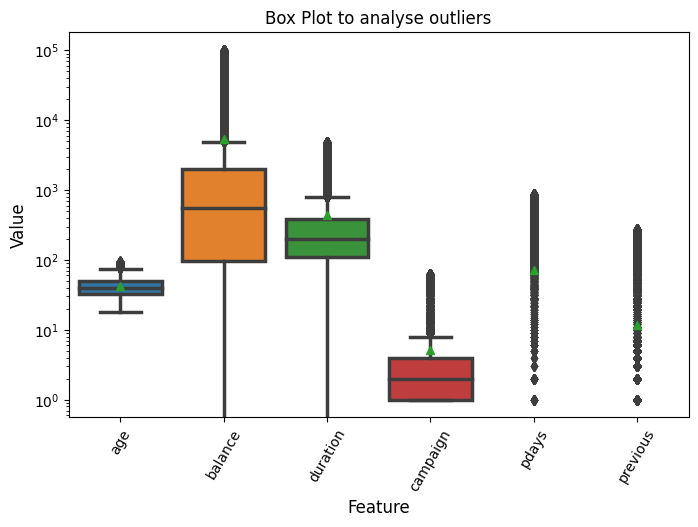

In [23]:
fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(data=train_data, linewidth=2.5, ax=ax, showmeans=True).set_yscale("log")
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.xticks(rotation=60);
plt.title("Box Plot to analyse outliers")

"Balance," "pdays," and "previous" have the most outliers, suggesting significant variability.
There are outliers in almost all of the features, indicating proper data preprocessin gto handee these outliers.

# **Data Preprocessing**

### Handle Dates
Th **last contact date** column can be broken down ino ****day, month and year****  feature respectively.

In [24]:
def date_transform(df, date_column):
    df[date_column] = pd.to_datetime(df[date_column])
    df['contact_month'] = df[date_column].dt.month
    df['contact_day'] = df[date_column].dt.day
    df.drop(columns=[date_column, df[date_column].dt.year.name], inplace=True)
    return df

In [25]:
date_feature = 'last contact date'

# Apply date transformation function
df = date_transform(df, date_feature)

### Handle loan features

In [26]:
# # # Housing and loan interaction
# df['has_both_loans'] = ((df['housing'] == 'yes') & (df['loan'] == 'yes')).astype(int)
# df['no_loans'] = ((df['housing'] == 'no') & (df['loan'] == 'no')).astype(int)

### Handle Balance
Similar to age, the balance feature can be categorized to different categories such as low, medium and high. We can call this feature balance_category.

We can use KBinsDiscretizer to convert the continuous features into discrete intervals. This can help the model better understand the data.

In [27]:
# from sklearn.preprocessing import KBinsDiscretizer

# est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
# df['balance_category'] = est.fit_transform(df[['balance']])

# # Map the numerical categories to labels (low, medium, high)
# df['balance_category'] = df['balance_category'].map({0: 'low', 1: 'medium', 2: 'high'})
# df = df.drop('balance', axis = 1)
# df.head(2)

### Handle Duration
Similary, we handle the duration and break this feature down into 3 different categories, short, medium and long depending upon the call duration.

In [28]:
# est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
# df['duration_category'] = est.fit_transform(df[['duration']])

# # Map the numerical categories to labels (short, medium, long)
# df['duration_category'] = df['duration_category'].map({0: 'short', 1: 'medium', 2: 'long'})
# df = df.drop('duration', axis = 1)
# df.head(2)

### Handle Campaign

In [29]:
# est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
# df['campaign_category'] = est.fit_transform(df[['campaign']])

# # Map the numerical categories to labels (low, medium, high)
# df['campaign_category'] = df['campaign_category'].map({0: 'low', 1: 'medium', 2: 'high'})
# df = df.drop("campaign", axis = 1)
# df.head(2)

### Handle pdays feature

converting the value "-1" to nan for simplification of the process.

In [30]:
# Convert -1 in pdays to NaN (no previous contact)
df.loc[df['pdays'] == -1, 'pdays'] = np.nan

# Convert 'unknown' values to NaN
df.replace('unknown', np.nan, inplace=True)
df.replace('NaN', np.nan, inplace=True)
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target,contact_month,contact_day
0,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331.0,1,other,no,4,17
1,52,technician,married,secondary,no,553,yes,no,telephone,160,1,NaN,0,NaN,no,10,11


### Handle NAN values

In [31]:
df.replace('NaN', np.nan, inplace=True)
null_values = df.isnull().sum()
null_values

age                  0
job                229
marital              0
education         1467
default              0
balance              0
housing              0
loan                 0
contact          10336
duration             0
campaign             0
pdays            29446
previous             0
poutcome         29451
target               0
contact_month        0
contact_day          0
dtype: int64

In [32]:
df['contact'].unique()

array(['cellular', 'telephone', nan], dtype=object)

We can fill all the Nan of contact with "unknown".

In [33]:
df['contact'] = df['contact'].fillna('unknown')

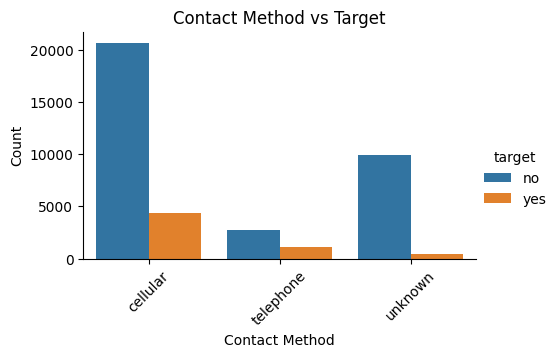

In [34]:
sns.catplot(x='contact', hue='target', kind='count', data=df, height=3, aspect=5/3)
plt.title('Contact Method vs Target')
plt.xlabel('Contact Method')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Let us check the unique values of the poutcome.

In [35]:
df['poutcome'].unique()

array(['other', nan, 'failure', 'success'], dtype=object)

In [36]:
df['poutcome'] = df['poutcome'].fillna('unknown') ## replacing nan values of poutcome with 'unknown'

In [37]:
null_values = df.isnull().sum()
null_values

age                  0
job                229
marital              0
education         1467
default              0
balance              0
housing              0
loan                 0
contact              0
duration             0
campaign             0
pdays            29446
previous             0
poutcome             0
target               0
contact_month        0
contact_day          0
dtype: int64

There are only **age**, **education** and **pdays** with some null values. We can handle them with Imputation techniques in the pipeline.

### Splitting the train_data into X and y
Splitting the data into X and y before training the model.

In [38]:
y = df['target']
X = df.drop('target', axis=1)
print(X.shape, y.shape)

(39211, 16) (39211,)


In [39]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            39211 non-null  int64  
 1   job            38982 non-null  object 
 2   marital        39211 non-null  object 
 3   education      37744 non-null  object 
 4   default        39211 non-null  object 
 5   balance        39211 non-null  int64  
 6   housing        39211 non-null  object 
 7   loan           39211 non-null  object 
 8   contact        39211 non-null  object 
 9   duration       39211 non-null  int64  
 10  campaign       39211 non-null  int64  
 11  pdays          9765 non-null   float64
 12  previous       39211 non-null  int64  
 13  poutcome       39211 non-null  object 
 14  contact_month  39211 non-null  int32  
 15  contact_day    39211 non-null  int32  
dtypes: float64(1), int32(2), int64(5), object(8)
memory usage: 4.5+ MB


In [40]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target,contact_month,contact_day
0,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331.0,1,other,no,4,17
1,52,technician,married,secondary,no,553,yes,no,telephone,160,1,NaN,0,unknown,no,10,11
2,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,NaN,0,unknown,no,11,20
3,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,NaN,0,unknown,no,9,1
4,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,NaN,0,unknown,no,1,29


### Setup processing pipeline- Imputation is done using SimpleImputation for the missing values
- then scaled the features with appropriate scalers
- Encoded using OrdinalEncoder and OneHotEncoder
- Then transformed the train data with column transformer.

In [41]:
# Define feature groups
numeric_features = ['age', 'balance', 'duration', 'campaign', 'previous']
categorical_features = ['job', 'marital', 'education', 'contact', 'poutcome']
binary_features = ['default', 'housing', 'loan']
pdays_prep=['pdays']
target = 'target'

# Pipelines for each type of feature
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

pdays_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='constant',fill_value=0)),
    ('scaler',MaxAbsScaler())
])

binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('label_encoder', OrdinalEncoder())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])


# Combine all preprocessing steps with ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('pdays',pdays_pipeline,pdays_prep),
    ('bin', binary_pipeline, binary_features),
    ('cat', categorical_pipeline, categorical_features)
],remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['age', 'balance', 'duration', 'campaign',
                                  'previous']),
                                ('pdays',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scaler', MaxAbsScaler())]),
                                 ['pdays']),
                                ('bin',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('label_encoder',
                                                  OrdinalEncoder())]),
                                 ['default', 'housing', 'loan']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['job', 'marital', 'education', 'contact',
                                  'poutcome'])])

In [42]:
X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed = pd.DataFrame(X_preprocessed,columns=preprocessor.get_feature_names_out())
X_preprocessed.head()

,num__age,num__balance,num__duration,num__campaign,num__previous,pdays__pdays,bin__default,bin__housing,bin__loan,cat__job_admin.,...,cat__education_tertiary,cat__contact_cellular,cat__contact_telephone,cat__contact_unknown,cat__poutcome_failure,cat__poutcome_other,cat__poutcome_success,cat__poutcome_unknown,remainder__contact_month,remainder__contact_day
0,0.103896,0.078677,0.072590,0.016129,0.003636,0.380023,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,17.0
1,0.441558,0.077824,0.032534,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,10.0,11.0
2,0.337662,0.085487,0.066287,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,20.0
3,0.194805,0.076380,0.021147,0.032258,0.000000,0.000000,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,9.0,1.0
4,0.168831,0.074047,0.090484,0.016129,0.000000,0.000000,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,29.0


In [43]:
pd.DataFrame(X_preprocessed,columns=preprocessor.get_feature_names_out()).columns

Index(['num__age', 'num__balance', 'num__duration', 'num__campaign',
       'num__previous', 'pdays__pdays', 'bin__default', 'bin__housing',
       'bin__loan', 'cat__job_admin.', 'cat__job_blue-collar',
       'cat__job_entrepreneur', 'cat__job_housemaid', 'cat__job_management',
       'cat__job_retired', 'cat__job_self-employed', 'cat__job_services',
       'cat__job_student', 'cat__job_technician', 'cat__job_unemployed',
       'cat__marital_divorced', 'cat__marital_married', 'cat__marital_single',
       'cat__education_primary', 'cat__education_secondary',
       'cat__education_tertiary', 'cat__contact_cellular',
       'cat__contact_telephone', 'cat__contact_unknown',
       'cat__poutcome_failure', 'cat__poutcome_other', 'cat__poutcome_success',
       'cat__poutcome_unknown', 'remainder__contact_month',
       'remainder__contact_day'],
      dtype='object')

### Encode target variable

In [44]:
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)
pd.DataFrame(y, columns=['target']).value_counts()

target
0         33384
1          5827
Name: count, dtype: int64

In [45]:
X_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   num__age                  39211 non-null  float64
 1   num__balance              39211 non-null  float64
 2   num__duration             39211 non-null  float64
 3   num__campaign             39211 non-null  float64
 4   num__previous             39211 non-null  float64
 5   pdays__pdays              39211 non-null  float64
 6   bin__default              39211 non-null  float64
 7   bin__housing              39211 non-null  float64
 8   bin__loan                 39211 non-null  float64
 9   cat__job_admin.           39211 non-null  float64
 10  cat__job_blue-collar      39211 non-null  float64
 11  cat__job_entrepreneur     39211 non-null  float64
 12  cat__job_housemaid        39211 non-null  float64
 13  cat__job_management       39211 non-null  float64
 14  cat__j

### Handle data imbalance
From the EDA section, we know that the target variable is highly imbalanced. So let us use SMOTE, which is an over sampling method to handle the imbalance in the dataset.

In [46]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X_preprocessed, y)
print(X_resampled.shape, y_resampled.shape)

(66768, 35) (66768,)


### Splitting data
We split the dataset into training and testing setThis will hep me to carry out preprocessing steps to train my model..

In [47]:
X_train,X_test,y_train,y_test=train_test_split(X_resampled, y_resampled,test_size=.20,random_state=42)
print(f"X train shape: {X_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"y train shape: {y_train.shape}")
print(f"y test shape: {y_test.shape}")

X train shape: (53414, 35)
X test shape: (13354, 35)
y train shape: (53414,)
y test shape: (13354,)


# Model Training

## Base Model - Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

logreg = LogisticRegression(random_state=42)

logreg.fit(X_train, y_train)

logreg_y_pred = logreg.predict(X_test)

# Calculate F1 score
logreg_f1 = f1_score(y_test, logreg_y_pred, average='macro')
print(f"Logistic Regression F1-score: {logreg_f1:.2f}")

Logistic Regression F1-score: 0.79


## SGDClassifier 

In [49]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)

sgd.fit(X_train, y_train)

sgd_y_pred = sgd.predict(X_test)

# Calculate F1 score
sgd_f1 = f1_score(y_test, sgd_y_pred, average='macro')
print(f"SGD Classifier F1-score: {sgd_f1:.2f}")

SGD Classifier F1-score: 0.72


## K Nearest Neighbors

In [50]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)  

#fitting the train set
knn_model.fit(X_train, y_train)

# Predict and evaluate
knn_y_pred = knn_model.predict(X_test)
knn_f1 = f1_score(y_test, knn_y_pred, average='macro')
print(f"K-Nearest Neighbors F1-score: {knn_f1:.4f}")

K-Nearest Neighbors F1-score: 0.8763


In [51]:
## checking the score on both train and test dataset
knn_model.score(X_train, y_train), knn_model.score(X_test, y_test)

(0.9369079267607743, 0.8772652388797364)

## RandomForestClassifier

In [52]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

rf_y_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred, average='macro')

print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"Random Forest F1-score: {rf_f1:.2f}")

Random Forest Accuracy: 0.93
Random Forest F1-score: 0.93


In [53]:
## checking the score on both train and test dataset
rf_clf.score(X_train, y_train), rf_clf.score(X_test, y_test)

(1.0, 0.9275123558484349)

So we can see 1.0 score on training data and 0.93 score on test data, clearly this model is overfitting the data. To avoid overfitting I need to do Hyper Parameter Tuning on this.

### Hyperparameter tuning with RandomForestClassifier

In [54]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report

# ## hyperparameter tuning using GridSearchCV of RandomForestClassifier
# param_grid = {
#     'n_estimators': [100, 200, 300],        
#     'max_depth': [10, 20, None],          
#     'min_samples_split': [2, 5, 10],      
#     'min_samples_leaf': [1, 2, 4]  
# }
# grid_search = GridSearchCV(
#     estimator=rf_clf,
#     param_grid=param_grid,
#     scoring='f1_macro',  # Use F1-macro score as the evaluation metric
#     cv=3,  # 3-fold cross-validation
# )

# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print("Best F1 Macro Score:", grid_search.best_score_)
'''The score from Hyperparameter tuning od RandomForestClassifier is 0.92 only which is similar to the previous score.'''


'The score from Hyperparameter tuning od RandomForestClassifier is 0.92 only which is similar to the previous score.'

In [55]:
# best_rf_model = grid_search.best_estimator_
# y_pred = best_rf_model.predict(X_test)

# print(classification_report(y_test, y_pred))

## XGBClassifier

In [56]:
from xgboost import XGBClassifier

# Train the XGBoost model
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

xgb_y_pred = xgb_clf.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred, average='macro')

print(f"XGBoost Accuracy: {xgb_accuracy:.2f}")
print(f"XGBoost F1-score: {xgb_f1:.2f}")

XGBoost Accuracy: 0.92
XGBoost F1-score: 0.92


In [57]:
xgb_clf.score(X_train, y_train), xgb_clf.score(X_test, y_test)

(0.9647096266896319, 0.9236183914931856)

We can see 0.96 score on training data and 0.92 score on test data, clearly this model is overfitting the data. To avoid overfitting I need to do Hyper Parameter Tuning on this.

#### HyperParameter Tuning using GridSearchCV

In [58]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


# xgb_params = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 6, 10],
#     'learning_rate': [0.01, 0.1, 0.2]
# }
# xgb_grid = GridSearchCV(XGBClassifier(), 
#                         xgb_params, 
#                         scoring='f1_macro',
#                         cv=5)
# xgb_grid.fit(X_train, y_train)

# # Retrieve the best model from grid search
# best_xgb = xgb_grid.best_estimator_

# # Predict on test data and evaluate
# xgb_y_pred_tuned = best_xgb.predict(X_test)

# xgb_tuned_accuracy = accuracy_score(y_test, xgb_y_pred_tuned)
# xgb_tuned_f1 = f1_score(y_test, xgb_y_pred_tuned, average='macro')

# # Print results
# print("XGBoost - Tuned Model")
# print(f"Accuracy: {xgb_tuned_accuracy:.2f}")
# print(f"F1 Score: {xgb_tuned_f1:.2f}")

# cm=confusion_matrix(y_test, xgb_y_pred_tuned)
# cd=ConfusionMatrixDisplay(confusion_matrix=cm)
# cd.plot()

'''XGBoost - Tuned Model
   Accuracy: 0.93
   F1 Score: 0.93'''

'XGBoost - Tuned Model\n   Accuracy: 0.93\n   F1 Score: 0.93'

In [59]:
# best_xgb.fit(X_train, y_train)
# best_xgb.score(X_train, y_train), best_xgb.score(X_test, y_test)

In [60]:
# from sklearn.metrics import classification_report
# # Classification Report
# print(classification_report(y_test, xgb_y_pred_tuned))

Hyperparameter tuning with GridsearchCV didn't improve the public score .

So I will try with **RandomizedSearchCV**

#### HyperParameter Tuning using RandomizedSearchCV

In [61]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
param_distributions = {
    'n_estimators': [100, 200, 300],     
    'max_depth': [3, 5, 7],                     
    'learning_rate': [0.01, 0.05, 0.1],        
}
random_search = RandomizedSearchCV(
    estimator= XGBClassifier(),
    param_distributions=param_distributions,
    n_iter=50,                # Number of random parameter combinations to try
    scoring='f1_macro',       # Use F1-macro score as the evaluation metric
    cv=5,                     # 3-fold cross-validation
)

random_search.fit(X_train, y_train)

best_xgb_model = random_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

print(classification_report(y_test, y_pred))

xgb_tuned_accuracy = accuracy_score(y_test, y_pred)
xgb_tuned_f1 = f1_score(y_test, y_pred, average='macro')

# Print results
print("XGBoost - Tuned Model")
print(f"Accuracy: {xgb_tuned_accuracy:.2f}")
print(f"F1 Score: {xgb_tuned_f1:.2f}")

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      6548
           1       0.93      0.92      0.93      6806

    accuracy                           0.93     13354
   macro avg       0.93      0.93      0.93     13354
weighted avg       0.93      0.93      0.93     13354

XGBoost - Tuned Model
Accuracy: 0.93
F1 Score: 0.93


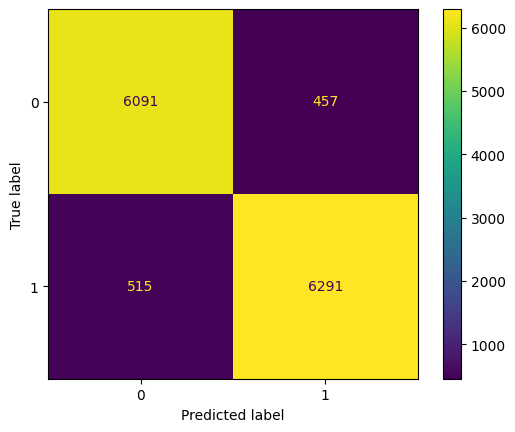

In [62]:
cm=confusion_matrix(y_test, y_pred)
cd=ConfusionMatrixDisplay(confusion_matrix=cm)
cd.plot()

# FEATURE ENGINEERING

#### PCA - Principal Component Analysis

In [63]:
# from sklearn.decomposition import PCA

# # Initialize PCA and fit it to the training data
# pca = PCA(n_components=0.95)  # Retain 95% of variance
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

# print(f"Original number of features: {X_train.shape[1]}")
# print(f"Reduced number of features: {X_train_pca.shape[1]}")

In [64]:
# # Train the Random Forest model
# from sklearn.ensemble import RandomForestClassifier

# rf_clf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_clf_pca.fit(X_train_pca, y_train)

# rf_y_pred_pca = rf_clf_pca.predict(X_test_pca)
# rf_accuracy = accuracy_score(y_test, rf_y_pred_pca)

# rf_f1 = f1_score(y_test, rf_y_pred_pca, average='macro')
# print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
# print(f"Random Forest F1-score: {rf_f1:.4f}")

I did PCA and reduced the number of features from 37 to only 2. Previously the f1-macro score was 0.93 and after PCA, it is 0.84. There is a huge difference in the scores. So I believe we can stick to the original score and implementation.

#### Reduced Feature Elimination

In [65]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rf_classifier, n_features_to_select=10)  
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

random_rfe = RandomForestClassifier(random_state=42)
random_rfe.fit(X_train[selected_features], y_train)
rf_rfe_y_pred = random_rfe.predict(X_test[selected_features])

rf_accuracy = accuracy_score(y_test, rf_rfe_y_pred)
rf_f1 = f1_score(y_test, rf_rfe_y_pred, average='macro')

print(f"Random Forest Accuracy with Selected Features: {rf_accuracy:.2f}")
print(f"Random Forest F1-score with Selected Features: {rf_f1:.2f}")

Selected Features: Index(['num__age', 'num__balance', 'num__duration', 'num__campaign',
       'num__previous', 'pdays__pdays', 'bin__housing',
       'cat__poutcome_success', 'remainder__contact_month',
       'remainder__contact_day'],
      dtype='object')
Random Forest Accuracy with Selected Features: 0.92
Random Forest F1-score with Selected Features: 0.92


RFE with few selected features has reduced the score to 0.92 which is lesser than 0.93 of XGBoost.

# Test data

In [66]:
test_data.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2009-11-21,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,2010-02-04,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,2010-07-28,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN
3,2010-06-09,38,admin.,married,primary,no,1487,no,no,NaN,332,2,-1,0,NaN
4,2008-03-02,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure


### Test data preprocessing

In [67]:
def date_transform(df, date_column):
    df[date_column] = pd.to_datetime(df[date_column])
    df['contact_month'] = df[date_column].dt.month
    df['contact_day'] = df[date_column].dt.day
    # Extract year and drop immediately
    df.drop(columns=[date_column, df[date_column].dt.year.name], inplace=True)
    return df
    
date_feature = 'last contact date'

# Apply date transformation function
test_data = date_transform(test_data, date_feature)

In [68]:
# # Housing and loan interaction
# test_data['has_both_loans'] = ((test_data['housing'] == 'yes') & (test_data['loan'] == 'yes')).astype(int)
# test_data['no_loans'] = ((test_data['housing'] == 'no') & (test_data['loan'] == 'no')).astype(int)

In [69]:
# import pandas as pd
# import matplotlib.pyplot as plt

# bins = [0, 25, 50, float('inf')]
# labels = ['young', 'middle', 'old']
# test_data['age_group'] = pd.cut(test_data['age'], bins=bins, labels=labels, right=False)
# test_data = test_data.drop('age', axis=1)
# test_data.head(2)

In [70]:
# from sklearn.preprocessing import KBinsDiscretizer

# est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
# test_data['balance_category'] = est.fit_transform(test_data[['balance']])

# # Map the numerical categories to labels (low, medium, high)
# test_data['balance_category'] = test_data['balance_category'].map({0: 'low', 1: 'medium', 2: 'high'})
# test_data = test_data.drop('balance', axis = 1)
# test_data.head(2)

In [71]:
# est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
# test_data['duration_category'] = est.fit_transform(test_data[['duration']])

# # Map the numerical categories to labels (short, medium, long)
# test_data['duration_category'] = test_data['duration_category'].map({0: 'short', 1: 'medium', 2: 'long'})
# # df = df.drop('duration', axis = 1)
# test_data.head(2)

In [72]:
# est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
# test_data['campaign_category'] = est.fit_transform(test_data[['campaign']])

# # Map the numerical categories to labels (low, medium, high)
# test_data['campaign_category'] = test_data['campaign_category'].map({0: 'low', 1: 'medium', 2: 'high'})
# test_data = test_data.drop('campaign', axis = 1)
# test_data.head(2)

In [73]:
test_data['contact'] = test_data['contact'].fillna('unknown')

In [74]:
test_data['poutcome'] = test_data['poutcome'].fillna('unknown')

In [75]:
# Convert -1 in pdays to NaN (no previous contact)
test_data.loc[test_data['pdays'] == -1, 'pdays'] = np.nan

# Convert 'unknown' values to NaN
test_data.replace('unknown', np.nan, inplace=True)
test_data.replace('NaN', np.nan, inplace=True)
test_data.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,contact_month,contact_day
0,36,management,single,tertiary,no,7,no,no,NaN,20,1,NaN,0,NaN,11,21
1,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,NaN,0,NaN,2,4


In [76]:
# Preprocess the test data using the preprocessor pipeline
test_data_processed = preprocessor.transform(test_data)
test_data_processed = pd.DataFrame(test_data_processed,columns=preprocessor.get_feature_names_out())
test_data_processed.head()

,num__age,num__balance,num__duration,num__campaign,num__previous,pdays__pdays,bin__default,bin__housing,bin__loan,cat__job_admin.,...,cat__education_tertiary,cat__contact_cellular,cat__contact_telephone,cat__contact_unknown,cat__poutcome_failure,cat__poutcome_other,cat__poutcome_success,cat__poutcome_unknown,remainder__contact_month,remainder__contact_day
0,0.233766,0.072867,0.004067,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,21.0
1,0.155844,0.082491,0.015860,0.016129,0.000000,0.000000,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0
2,0.181818,0.073548,0.017487,0.048387,0.000000,0.000000,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,28.0
3,0.259740,0.086304,0.067507,0.016129,0.000000,0.000000,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,9.0
4,0.532468,0.075663,0.120171,0.000000,0.007273,0.202067,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0


In [77]:
test_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   num__age                  10000 non-null  float64
 1   num__balance              10000 non-null  float64
 2   num__duration             10000 non-null  float64
 3   num__campaign             10000 non-null  float64
 4   num__previous             10000 non-null  float64
 5   pdays__pdays              10000 non-null  float64
 6   bin__default              10000 non-null  float64
 7   bin__housing              10000 non-null  float64
 8   bin__loan                 10000 non-null  float64
 9   cat__job_admin.           10000 non-null  float64
 10  cat__job_blue-collar      10000 non-null  float64
 11  cat__job_entrepreneur     10000 non-null  float64
 12  cat__job_housemaid        10000 non-null  float64
 13  cat__job_management       10000 non-null  float64
 14  cat__jo

The Hyperparameter tuned model using GridSearchCV gave lesser public score (i.e; 0.71965) and with RandomizedSearchCV tuned model gave 0.72343 public score.

Therefore , I have selected the later one to predict on the test_data.

In [78]:
# Now make model predictions of the preprocessed test_data 
# Predict using XGBoost
xb_test_pred = best_xgb_model.predict(test_data_processed)

In [79]:
pd.DataFrame(xb_test_pred, columns=['target']).value_counts()

target
0         8393
1         1607
Name: count, dtype: int64

In [80]:
pd.DataFrame(test_data_processed,columns=preprocessor.get_feature_names_out()).shape

(10000, 35)

## Submitting to the competition using XGBClassifier

In [81]:
submission = pd.DataFrame({
    'id': range(len(xb_test_pred)),  # Replace 'ID' with the actual ID column name in your test dataset
    'target': xb_test_pred
})

# Step 4: Convert binary predictions to 'yes'/'no' format
submission['target'] = submission['target'].apply(lambda x: 'yes' if x == 1 else 'no')

# Step 5: Save as CSV
submission.to_csv('submission.csv', index=False)